In [4]:
from dotenv import load_dotenv
from metagame import TradingClient
import os

load_dotenv()

client = TradingClient(
    api_url=os.environ["API_URL"],
    jwt=os.environ["JWT"],
    act_as=int(os.environ["ACT_AS"]),
)

/workspaces/platform/python-client/.venv/lib/python3.12/site-packages/stringcase.py:247: SyntaxWarning: invalid escape sequence '\W'
  return re.sub("\W+", "", string)


In [5]:
import pandas as pd

def get_best_bid_offer(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)
    if market_id is None:
        return pd.Series()
    bids = state.markets[market_id].bids
    offers = state.markets[market_id].offers
    return pd.Series({
        "bid": bids[0].price if bids else None,
        "offer": offers[0].price if offers else None
    })

get_best_bid_offer("At 6PM Saturday, resolves to 20 if I believe a camp participant has >=4000 clips")

bid      0.0
offer    NaN
dtype: float64

In [1]:
def get_market_trades(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)    
    if market_id is None:
        return pd.DataFrame()

    if not state.markets[market_id].hasFullTradeHistory:
        client.get_full_trade_history(market_id)
        state = client.state()

    trades = state.markets[market_id].trades
    if not trades:
        return pd.DataFrame()
    df = pd.DataFrame(trades).set_index("id")
    df["buyer"] = df["buyer_id"].map(lambda x: state.accounts[x].name)
    df["seller"] = df["seller_id"].map(lambda x: state.accounts[x].name)
    return df.drop(columns=["market_id", "buyer_id", "seller_id"])


In [2]:
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from datetime import timedelta

try:
    while True:
        display(get_best_bid_offer("test_bond"))
        trades = get_market_trades("alpha_tradewars").set_index("transaction_timestamp")
        if not trades.empty:
            fig, ax = plt.subplots()
            ax.plot(trades.price, label="Price")
            ax.set_ylabel("Price")
            twin = ax.twinx()
            rolling_volume = trades["size"].rolling(timedelta(minutes=0.5)).sum()
            twin.fill_between(trades.index, rolling_volume, color="orange", alpha=0.3, label="Rolling Volume")
            twin.set_ylabel("Rolling Volume")
            ax.legend(loc='upper left')
            twin.legend(loc='upper right')
            display(fig)
        client.wait_portfolio_update()
        clear_output(wait=True)
except KeyboardInterrupt:
    clear_output(wait=True)

NameError: name 'get_best_bid_offer' is not defined

In [ ]:
from metagame.websocket_api import Order

def order_size_at_transaction(order: Order, transaction_id: int) -> float:
    for size in reversed(order.sizes):
        if size.transaction_id <= transaction_id:
            return size.size
    return 0.0

def get_bbo_history(market_name: str):
    state = client.state()
    market_id = state.market_name_to_id.get(market_name)    
    if market_id is None:
        return pd.DataFrame()

    if not state.markets[market_id].hasFullOrderHistory:
        client.get_full_order_history(market_id)
        state = client.state()

    orders = state.markets[market_id].orders
    bids = state.markets[market_id].bids
    offers = state.markets[market_id].offers
    if not orders:
        return pd.DataFrame()

    transaction_timestamp_by_id = {size.transaction_id: size.transaction_timestamp for o in orders for size in o.sizes}
    transaction_ids = sorted(transaction_timestamp_by_id)
    transaction_timestamps = [
        transaction_timestamp_by_id[t]
        for t in transaction_ids
    ]
    best_bids = [
        next((b for b in bids if order_size_at_transaction(b, t) > 0.0), None)
        for t in transaction_ids
    ]
    best_offers = [
        next((o for o in offers if order_size_at_transaction(o, t) > 0.0), None)
        for t in transaction_ids
    ]
    df = pd.DataFrame({
        "transaction_id": transaction_ids,
        "timestamp": transaction_timestamps,
        "best_bid_price": [b.price if b is not None else None for b in best_bids],
        "best_bid_size": [
            order_size_at_transaction(b, t) if b is not None else None
            for b, t in zip(best_bids, transaction_ids)
        ],
        "best_offer_price": [o.price if o is not None else None for o in best_offers],
        "best_offer_size": [
            order_size_at_transaction(o, t) if o is not None else None
            for o, t in zip(best_offers, transaction_ids)
        ]
    })
    return df.drop_duplicates(
        subset=["best_bid_price", "best_bid_size", "best_offer_price", "best_offer_size"]
    ).set_index("transaction_id")

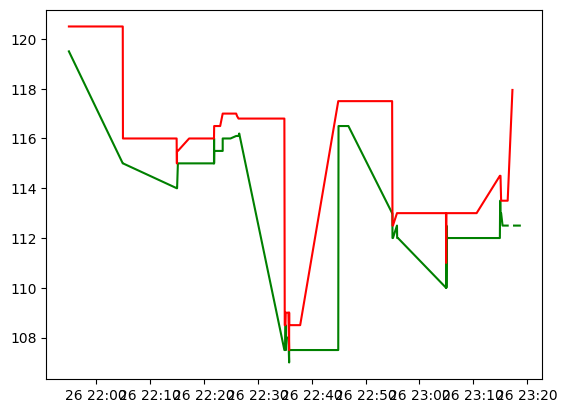

In [ ]:
bbo_history = get_bbo_history("alpha_tradewars")
fig, ax = plt.subplots()
_ = ax.plot(bbo_history.timestamp, bbo_history.best_bid_price, color="green")
_ = ax.plot(bbo_history.timestamp, bbo_history.best_offer_price, color="red")

In [ ]:
def get_market_positions(market_name: str):
    df = get_market_trades(market_name)
    if df.empty:
        return pd.DataFrame()
    return pd.concat([
        df.groupby("buyer")["size"].sum(),
        -df.groupby("seller")["size"].sum()
    ]).groupby(level=0).sum()

def get_multiple_market_positions(market_names: list[str]):
    return pd.DataFrame({market: get_market_positions(market) for market in market_names}).fillna(0)

In [10]:
state = client.state()
accounts = [{"id": account.id, "name": account.name, "value": state.portfolios.get(account.id)} for account in state.accounts]
print(accounts)

[{'id': 0, 'name': 'Hidden', 'value': None}, {'id': 1, 'name': 'Ross Rheingans-Yoo', 'value': None}, {'id': 2, 'name': 'Nicholas Charette', 'value': None}, {'id': 3, 'name': 'Yoav Tzfati', 'value': None}, {'id': 4, 'name': 'Mark Rychnovsky', 'value': None}, {'id': 5, 'name': 'Ricki Heicklen', 'value': None}, {'id': 6, 'name': 'Tanmay Khale', 'value': None}, {'id': 7, 'name': 'Nicholas Charette-82b3972', 'value': None}, {'id': 8, 'name': 'Matt Connor', 'value': None}, {'id': 9, 'name': 'Elizabeth Garrett', 'value': None}, {'id': 10, 'name': 'Bogdan Enache', 'value': None}, {'id': 11, 'name': 'Rachel Weinberg', 'value': None}, {'id': 12, 'name': 'Andy Rapista', 'value': None}, {'id': 13, 'name': 'Ethan Anderson', 'value': None}, {'id': 14, 'name': 'Neal Shrestha', 'value': None}, {'id': 15, 'name': 'Tony Deng', 'value': Portfolio(account_id=15, total_balance=1127.0048, available_balance=1127.0048, market_exposures=[], owner_credits=[])}, {'id': 16, 'name': 'Paul Yea', 'value': None}, {'i